In [3]:
import h3
import h3pandas
import numpy as np
import pandas as pd
import pydeck as pdk
import seaborn as sns
import networkx as nx
from cflp_function import *
from shapely.geometry import Polygon
from calculate_od import *
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

In [4]:
# import os
# os.environ['USE_PYGEOS'] = '0'
# import geopandas as gpd

In [9]:
hex = pd.read_csv('./hex/hex_df2.csv')
# get_fill_color(hex, "fuzzy", "viridis")

In [6]:
# Define a layer to display on a map
# layer = pdk.Layer(
#     "H3HexagonLayer",
#     hex,
#     pickable=True,
#     # stroked=True,
#     filled=True,
#     extruded=False,
#     auto_highlight=True,
#     opacity=0.6,
#     get_hexagon="hex9",
#     get_fill_color = 'color', 
#     get_line_color=[255, 255, 255],
#     line_width_min_pixels=0.1
#     )

# # Set the viewport location
# view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=9, bearing=0, pitch=0)

# # Render
# r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Value: {fuzzy}"})
# r.to_html("layer.html")

### H3 indices and polygon geometries
We want to have a geodataframe that stores the H3 indices in study area and the polygon geometries

In [12]:
lst = gpd.read_file('./h3.shp')

OSError: Error loading pcre2-8-7c900f378c010e045d52efc64503ae31.dll; The operation completed successfully.

In [ ]:
idx = pd.DataFrame(index=lst.hex9)

In [ ]:
idx = idx.h3.h3_to_geo_boundary()

In [ ]:
idx = gpd.GeoDataFrame(idx, geometry='geometry', crs='EPSG:4326')

In [ ]:
# def cell_to_shapely_polygon(h3_index):
#     """
#     A function to convert H3 index to Shapely polygons

#     """
#     # hex_center_coords = h3.h3_to_geo(h3_index)
#     coords = h3.h3_to_geo_boundary(h3_index)
#     flipped = tuple(coord[::-1] for coord in coords)
#     # center_point = Point(hex_center_coords)
#     return Polygon(flipped) #, center_point

In [ ]:
# hex['geometry'] = hex['hex9'].apply(cell_to_shapely_polygon) # can change the function here
# gdf = gpd.GeoDataFrame(hex, geometry='geometry', crs=4326)

### Merge compound suitability map and H3 geometry information

In [ ]:
# gdf = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

### Spatial Autocorrelation

In [ ]:
w_queen = weights.Queen.from_dataframe(idx, use_index=True)

c:\Users\User\anaconda3\envs\scip\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 2 islands with ids: 891f16c693bffff, 891f1610e8fffff.
  warnings.warn(message)


In [ ]:
w_queen.min_neighbors

0

In [ ]:
w_queen.max_neighbors

6

In [ ]:
w_queen.islands

['891f16c693bffff', '891f1610e8fffff']

In [ ]:
# # view islands - those that don't have any neighbors
# ax=idx.plot(color='k', figsize=(6,6))
# idx.loc[w_queen.islands,:].plot(color='red', ax=ax)

In [ ]:
# Drop the islands
idx = idx.drop(w_queen.islands)

In [ ]:
# recalculate spatial weights matrix
w = weights.Queen.from_dataframe(idx, use_index=True)

c:\Users\User\anaconda3\envs\scip\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


In [ ]:
# Row standardize the matrix
w.transform = 'R'

In [20]:
# Reindex the compound suitability df such that its indices are ordered as the H3 list geodataframe
# hex_df = hex.set_index('hex9').reindex(idx.index)
hex_df = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

In [21]:
# Get standardised fuzzy values
hex_df['fuzzy_std'] = (hex_df['fuzzy'] - hex_df['fuzzy'].mean()) / hex_df['fuzzy'].std()

In [22]:
hex_df['lag_std'] = weights.lag_spatial(w, hex_df['fuzzy_std'])

In [23]:
hex_df['lag'] = weights.lag_spatial(w, hex_df['fuzzy'])

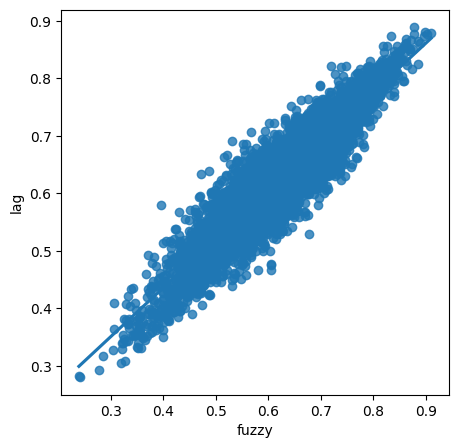

In [24]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='fuzzy', y='lag', data=hex_df, ci=None)
# Add vertical and horizontal lines
# plt.axvline(0, c='k', alpha=0.5)
# plt.axhline(0, c='k', alpha=0.5)
# # plt.text(1.75, 0.5, "HH", fontsize=25)
# # plt.text(1.5, -1.5, "HL", fontsize=25)
# # plt.text(-2, 1, "LH", fontsize=25)
# # plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

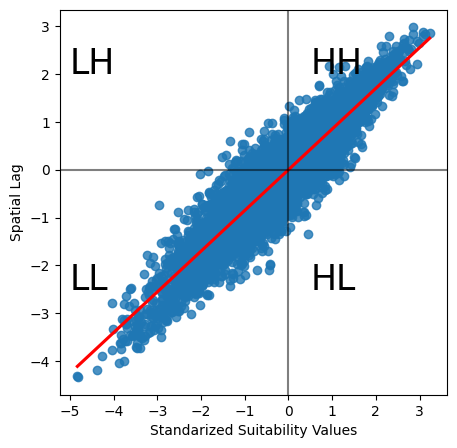

In [25]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='fuzzy_std', y='lag_std', data=hex_df, ci=None, line_kws=dict(color="r"))
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
ax.set_xlabel('Standarized Suitability Values')
plt.axhline(0, c='k', alpha=0.5)
ax.set_ylabel('Spatial Lag')
plt.text(0.5, 2, "HH", fontsize=25)
plt.text(0.5, -2.5, "HL", fontsize=25)
plt.text(-5, 2, "LH", fontsize=25)
plt.text(-5, -2.5, "LL", fontsize=25)
# Display
plt.show()

**Local Moran's I** tells you whether the local spatial pattern around each observation is similar to the overall pattern in the entire dataset.
**p_sim** is simulated p-values, which represent the probability of observing a similar or more extreme local spatial pattern under the assumption of spatial randomness.


In [26]:
lisa = esda.Moran_Local(hex_df['fuzzy'], w)
# Break observations into significant or not
hex_df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
hex_df['quadrant'] = lisa.q

In [27]:
hex_df['significant_0.01'] = lisa.p_sim < 0.01

In [28]:
np.sum(lisa.p_sim < 0.05)

4621

In [29]:
np.sum(lisa.p_sim < 0.01)

2794

In [30]:
# lisa_cluster(lisa, hex_df)

In [31]:
# plot_local_autocorrelation(lisa, hex_df, 'fuzzy')

In [32]:
# ax = hex_df.plot(color='k', figsize=(9, 9))
# hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].plot(color='red', ax=ax)
# ax.set_axis_off()

### HH Clusters to Connected Graphs

In [33]:
w

In [34]:
# pd.DataFrame(*w.full()).astype(int)

In [35]:
# Transform weight back to Binary
w.transform = 'B'

In [36]:
g = w.to_networkx()

In [37]:
print("Number of nodes:", nx.number_of_nodes(g))
print("Number of edges:", nx.number_of_edges(g))
# print("Nodes:", g.nodes())
# print("Edges:", g.edges())

Number of nodes: 11626
Number of edges: 31726


In [38]:
# NetworkX relabeled the nodes with integer starting from 0, we want the nodes to be labeled by their H3 index 
mapping = {new_index: old_index for new_index, old_index in enumerate(w.id_order)}

In [39]:
# Apply the mapping to the graph
g = nx.relabel_nodes(g, mapping)

In [40]:
# index_to_polygon = dict(zip(hex_df['hex9'], hex_df['geometry']))

In [41]:
# nx.set_node_attributes(g, index_to_polygon, 'coordinates')

In [42]:
# Get indices of H3 cells that are in the HH quadrant
HH = hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].hex9.to_list()

In [43]:
hh = hex_df[(hex_df['significant_0.01'] == True) & (hex_df['quadrant'] == 1)].hex9.to_list()

In [44]:
print(len(HH), len(hh))

2584 1593


In [45]:
# Get sub graph that includes only the HH quadrant
H = g.subgraph(HH)

In [46]:
h = g.subgraph(hh)

In [47]:
print("Number of nodes p=0.05:", nx.number_of_nodes(H))
print("Number of nodes p=0.01:", nx.number_of_nodes(h))

Number of nodes p=0.05: 2584
Number of nodes p=0.01: 1593


In [48]:
# nx.write_graphml(g, './g.graphml')

In [49]:
# nx.write_graphml(H, './H.graphml')

In [50]:
subH = list(nx.connected_components(H))

In [51]:
subh = list(nx.connected_components(h))

In [52]:
print(len(subH), len(subh))

74 75


In [53]:
# Get connected graphs without islands (connected graphs consist of a single node)
filter_subH = [component for component in subH if len(component) > 10]
filter_subh = [component for component in subh if len(component) > 10]

In [ ]:
filter_subh

[{'891f1619023ffff',
  '891f1619033ffff',
  '891f1619037ffff',
  '891f1619087ffff',
  '891f1619097ffff',
  '891f16190a3ffff',
  '891f16190a7ffff',
  '891f16190abffff',
  '891f16190afffff',
  '891f16190b3ffff',
  '891f16190b7ffff',
  '891f16190bbffff',
  '891f16191dbffff',
  '891f1619427ffff',
  '891f1619543ffff',
  '891f161954bffff',
  '891f161954fffff',
  '891f1619553ffff',
  '891f161955bffff'},
 {'891f1654113ffff',
  '891f1654117ffff',
  '891f1654133ffff',
  '891f1654137ffff',
  '891f1654183ffff',
  '891f1654187ffff',
  '891f165418bffff',
  '891f165418fffff',
  '891f1654193ffff',
  '891f1654197ffff',
  '891f165419bffff',
  '891f16541a3ffff',
  '891f16541a7ffff',
  '891f16541abffff',
  '891f16541afffff',
  '891f16541b3ffff',
  '891f16541b7ffff',
  '891f16541bbffff',
  '891f1654527ffff',
  '891f165452fffff',
  '891f1654c03ffff',
  '891f1654c0bffff',
  '891f1654c0fffff',
  '891f1654c13ffff',
  '891f1654c17ffff',
  '891f1654c1bffff',
  '891f1654c3bffff',
  '891f1654c47ffff',
  '891f1654c

In [54]:
print(len(filter_subH), len(filter_subh))

32 23


In [55]:
# Calculate eigenvector centrality for each connected component
eigenvector_centralities = []

for component in filter_subh:
    # Create a subgraph for the current connected component
    subgraph = h.subgraph(component)
    
    # Calculate eigenvector centrality for the subgraph
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    
    # Append the result to the list
    eigenvector_centralities.append(eigenvector_centrality)

In [64]:
# Print or use the list of eigenvector centralities as needed
for i, centrality in enumerate(eigenvector_centralities):
    print(f"Connected Component {i + 1}: {centrality}")

Connected Component 1: {'891f16190b7ffff': 0.26973427835405855, '891f1619553ffff': 0.09045616949803098, '891f1619023ffff': 0.06778431231044674, '891f16190a3ffff': 0.36818575560127764, '891f1619087ffff': 0.2431740639200566, '891f1619097ffff': 0.15837930811338533, '891f16190abffff': 0.23883366413318674, '891f161955bffff': 0.1736573885639183, '891f1619427ffff': 0.05811632922789013, '891f16190b3ffff': 0.3743611072767847, '891f16191dbffff': 0.14667897170430477, '891f1619037ffff': 0.14571801890725974, '891f1619543ffff': 0.17931075715056918, '891f16190bbffff': 0.26945158593035295, '891f161954bffff': 0.30293695770152756, '891f16190a7ffff': 0.23545017563287016, '891f161954fffff': 0.24784211471180698, '891f1619033ffff': 0.1623385896627614, '891f16190afffff': 0.28543610236750544}
Connected Component 2: {'891f16541abffff': 0.13368838616602233, '891f1656a53ffff': 0.10103896074417822, '891f1654c47ffff': 0.02323774506785137, '891f1656a6bffff': 0.21655057908375566, '891f1654117ffff': 0.089437570568295

In [65]:
# Get the node with the highest eigenvector centrality in each connected graph 
# site = pd.DataFrame(columns=['hex9','centrality'])
site = []

for centrality_dict in eigenvector_centralities:
    max_node_index = max(centrality_dict, key=centrality_dict.get)
    site.append(max_node_index)

In [72]:
site

['891f16190b3ffff',
 '891f16541b7ffff',
 '891f1619933ffff',
 '891f1646097ffff',
 '891f16115bbffff',
 '891f165689bffff',
 '891f1657497ffff',
 '891f16cc20bffff',
 '891f160b4dbffff',
 '891f1655ccfffff',
 '891f16c0b03ffff',
 '891f1610e73ffff',
 '891f16c6c2bffff',
 '891f16cca87ffff',
 '891f16c5b67ffff',
 '891f160aecfffff',
 '891f1652ec7ffff',
 '891f16c894fffff',
 '891f1619403ffff',
 '891f1610d43ffff',
 '891f165660bffff',
 '891f160a87bffff',
 '891f160b29bffff']

In [57]:
eigen = hex_df[['hex9','geometry']]

In [58]:
eigen['eigen_centrality'] = np.nan

c:\Users\User\anaconda3\envs\scip\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [69]:
eigen[eigen['hex9'].isin(site)].to_file('./site.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_18116\4034749117.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  eigen[eigen['hex9'].isin(site)].to_file('./site.shp')


In [60]:
# Fill in eigenvector centralities into the 'eigen' column based on 'hex9'
for centrality_dict in eigenvector_centralities:
    for node_index, centrality_value in centrality_dict.items():
        # Update the 'eigen' column with the corresponding centrality value
        eigen.loc[eigen['hex9'] == node_index, 'eigen_centrality'] = centrality_value

In [93]:
# eigen[~eigen['eigen_centrality'].isna()].to_file('./eigen.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_16556\477297101.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  eigen[~eigen['eigen_centrality'].isna()].to_file('./eigen.shp')


In [61]:
sub_size = [len(c) for c in sorted(nx.connected_components(H), key=len, reverse=True)]
sub_sizeh = [len(c) for c in sorted(nx.connected_components(h), key=len, reverse=True)]

In [2]:
# # Plotting the histogram
# plt.hist(sub_size, bins=30, edgecolor='black')
# plt.xlabel('Connected Component Size')
# plt.ylabel('Frequency')
# plt.title('Distribution of Connected Component Sizes')
# plt.show()

In [243]:
len(set(sub_size))

34

In [67]:
nH = list(H.nodes())

In [73]:
hex_df[hex_df['hex9'].isin(nH)].to_file('./n005.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_13476\3210048485.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_df[hex_df['hex9'].isin(nH)].to_file('./n005.shp')


In [74]:
hex_df[hex_df['hex9'].isin(list(h.nodes()))].to_file('./n001.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_13476\3482813778.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_df[hex_df['hex9'].isin(list(h.nodes()))].to_file('./n001.shp')


### Test

In [ ]:
def filter_sites():
# compute lisa
lisa = esda.Moran_Local(hex_df['fuzzy'], w)
# Break observations into significant or not
hex_df['significant'] = lisa.p_sim < 0.01
# Store the quadrant they belong to
hex_df['quadrant'] = lisa.q
# Get indices of H3 cells that are in the HH quadrant
HH = hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].hex9.to_list()
# Build sub graph that includes only the HH quadrant
H = g.subgraph(HH)
# Get sub components in the sub graphs
subH = list(nx.connected_components(H))
filter_subH = [component for component in subH if len(component) > 10]
# Calculate eigenvector centrality for each connected component
site_idx = []
for component in filter_subh:
    # Create a subgraph for the current connected component
    subgraph = h.subgraph(component)
    # Calculate eigenvector centrality for a connected graph
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    # Get the node index with the highest eigenvector centrality in that connected graph
    max_node_index = max(eigenvector_centrality, key=eigenvector_centrality.get)
    # Append the node index to a list
    site_idx.append(max_node_index)



In [60]:
from collections import Counter
# Use Counter to count occurrences of each value
value_counts = Counter(sub_size)

# Get the 10 most common values
most_common_values = value_counts.most_common(10)

# Display the result(f"{value}: {count}")
print("10 most common values and their counts:")
for value, count in most_common_values:
    print

10 most common values and their counts:
